In [118]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import LocallyLinearEmbedding, MDS, TSNE, Isomap

# Dimensionality reduction

* In high-dimensional space data behaves counterintuitively
* Point examples:
    * On unit square (2D) there's 0.4% chance a random point resides very close (0.001 from border) to one of the borders
    * On unit 10,000 hypercube (10,000D), there's 99.9999% chance a random point resides close to one of its borders
* Line examples:
    * On unit square (2D), two random points are on average 0.52 units apart
    * On unit cube (3D), two points are 0.66 units apart
    * On unit 1,000,000 hypercube, two points reside 408.3 units apart, which sounds counterintuitive
* High-dimensional datasets are at risk of being very sparse - most training instances are likely to be far apart from each other
* This makes prediction unreliable - risk of <font color='red'>**overfitting**</font>
<br>
* Two main approaches for dimensionality reduction:
    * **Projection**
    * **Manifold Learning**

## Projection

* In practice, training instances are **NOT** uniformly spread across all dimensions
* There are constant, highly correlated and randomly distributed features
* Consecuently, all training instances lie close to a much lower dimensional *subspace*
* As an example:

<img src="img/dim_red1.png" alt="Drawing" style="width: 500px;"/>

* In 3D these trainign instances are somewhat spread out 
* In 2D these training instances lie close to a plane 
* By projecting these points orthogonally to a plane we reduced dataset from 3D to 2D
* As a result, new features are optained

<img src="img/dim_red2.png" alt="Drawing" style="width: 300px;"/>

### PCA

0. *Principal Component Analysis*
1. Identifies the hyperplane that resides closest to the data
2. Projects the data onto it

#### Preserving the Variance

* Which hyperplane to choose?
* In the image below we have 2D data that is projected onto 3 different axes

<img src="img/dim_red3.png" alt="Drawing" style="width: 700px;"/>

* Solid line projects max variance
* Dotted line preservs little variance
* Dashed line preservs medium variance
* It is reasonable to select axis with max variance since it would preserve most information
* It is also supported by the fact that this axis minimizes the mean squared distnace between original dataset and its projection axis.

#### Principal Components

* PCA identifies axis for the max **variance**
* PCA identifies axis orthogonal to the first one with largest remaining variance. In 2D there's only two such components.
* <font color='red'>**NOTE!**</font> Generally there are $N-1$ orthogonal axes in $N$ dimensions. So PCA finds all those $N$ components 
* **Principal component** - the unit vector that defines the $i^{\text{th}}$ axis is called the $i^{\text{th}}$ prinical component
* In the figure above these principal components are marked $c_1$ and $c_2$ respectively.

<img src="img/dim_red4.png" alt="Drawing" style="width: 600px;"/>

<img src="img/dim_red5.png" alt="Drawing" style="width: 600px;"/>


#### Feature Variances

* Each *PC* has **explained variance ratio** that provides how much normalized variance each componetns has

In [56]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X.shape

(150, 4)

In [63]:
pca = PCA(n_components=4).fit(X, y)

print(iris.feature_names)
print(pca.explained_variance_ratio_)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[0.92461872 0.05306648 0.01710261 0.00521218]


* 92% of the variance of the dataset lies in **sepal length** feature


#### Choosing Features

* One can choose any number of dimensions from 1 to N
* But it is generally preferrable to choose features that add up to sufficiently large portion of the variance (e.g. 95%)
* For visualization purposes one usually goes for 2-3 features
* The variance can be specified by floating point number in `n_components` parameter in PCA() class. If the number is integer the PCA chhoses specified number of features

In [64]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
print("X_reduced shape: {}".format(X_reduced.shape))

[0.92461872 0.05306648]
X_reduced shape: (150, 2)


* Another option is to plot cumulative variances of the principal components

In [71]:
boston = datasets.load_boston()
boston.data.shape

(506, 13)

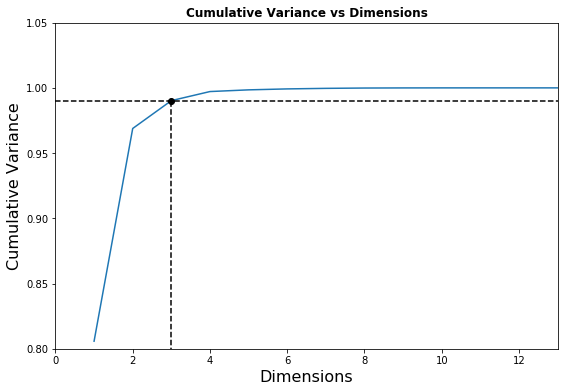

In [85]:
pca = PCA().fit(boston.data)

variances = pca.explained_variance_ratio_

plt.figure(figsize=(9, 6))
plt.plot(range(1, 14), np.cumsum(variances))
plt.plot([0, 14], [np.cumsum(variances)[2], np.cumsum(variances)[2]], ls='--', c='k')
plt.plot([3, 3], [0, np.cumsum(variances)[2]], ls='--', c='k')
plt.plot([3], [np.cumsum(variances)[2]], 'ko')
plt.axis([0, 13, 0.8, 1.05])
plt.title("Cumulative Variance vs Dimensions", weight='bold')
plt.xlabel("Dimensions", fontsize=16)
plt.ylabel("Cumulative Variance", fontsize=16)
plt.show()

* One can pick a point where cumulative variance stops growing fast.
* These dimensions describe the data the best - *intrinsic dimensions*
* Reducing 13D dataset to 3D wouldn't lose much variance

#### Memory Control

* PCA requires all the data to be in the memory at once
* For large datasets this would be impossible
* **Incremental PCA** can be trained incrementally with batches that fit into the memory
* One way to split the data is with NumPy's `np.array_split()` function
* **IncrementalPCA** does not use fit() method but rather `partial_fit()` on the mini-batches

In [86]:
# demonstrate it by extracting 154 fetaures from 784 in the MNIST dataset
mnist = datasets.fetch_openml('mnist_784', version=1)

In [88]:
X_mnist = mnist.data
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)

for X_batch in np.array_split(X_mnist, n_batches):
    inc_pca.partial_fit(X_batch)

X_mnist_reduced = inc_pca.transform(X_mnist)

In [89]:
print("X_mnist shape: {}".format(X_mnist.shape))
print("X_mnist_reduced shape: {}".format(X_mnist_reduced.shape))

X_mnist shape: (70000, 784)
X_mnist_reduced shape: (70000, 154)


#### Randomized PCA

* Stochastic algorithm that approximates first $d$ principal components
* Much faster than regular algorithm

In [90]:
rand_pca = PCA(n_components=154, svd_solver='randomized')
X_reduced = rand_pca.fit_transform(X_mnist)
X_reduced.shape

(70000, 154)

#### Kernel PCA

* Similarly to the Kernel Trick for SVM, where the algorithm maps intsances into higher-order dimensional space on the fly, a similar thing applys for **kPCA**
* <font color='red'>**REMINDER**</font>: Linear decision boundry in the high-D feature space corresponds to complex non-linear decision boundry in the *original space*
* **kPCA** allows complex nonlinear projections for dim-reduction
* It often preserves original clusters after projection or even un-rolling twisted manifolds

Let's apply KernelPCA on Swiss Roll dataset with 3 different kernels: linear, rbf, sigmoid (Logistic)

In [92]:
# load the data
X, t = datasets.make_swiss_roll(n_samples=1000, noise=0.2, random_state=0)

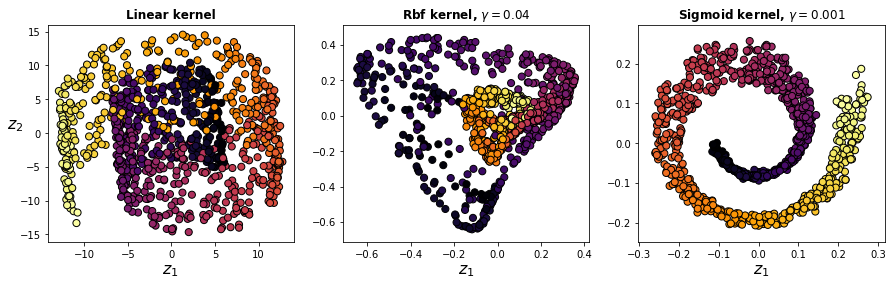

In [95]:
# create three pca models
lin_pca = KernelPCA(n_components=2, kernel='linear', n_jobs=-1)
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04, n_jobs=-1)
sigm_pca = KernelPCA(n_components=2, kernel='sigmoid', gamma=0.001, 
                     coef0=1, n_jobs=-1)

# plot the results
models = [lin_pca, rbf_pca, sigm_pca]
titles = ['Linear kernel', 'Rbf kernel, $\gamma=0.04$', 'Sigmoid kernel, $\gamma=0.001$']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for model, title, ax in zip(models, titles, axes.ravel()):
    X_red = model.fit_transform(X)
    ax.scatter(X_red[:, 0], X_red[:, 1], c=t, cmap='inferno', s=50, edgecolor='k', lw=1)
    ax.set_title(title, weight='bold')
    ax.set_xlabel('$z_1$', fontsize=16)
    if ax == axes.ravel()[0]:
        ax.set_ylabel('$z_2$', fontsize=16, rotation=0)
plt.show()

#### Kernel Selection & Hyperparameter Tuning

* As kPCA is an unsupervised learning technique, there isn't strickt performance measure to select the best kernel and thus hyperparameters
* Nevertheless, dim-reduction is often a prep work for supervised learning, thus one just has to try different kernels, hyperparameters that yiled best performance (accuracy for classification for instance)
* Let's use GridSearchCV for determining preferred kernel and hyperparameters

In [101]:
# use swiss roll as an example. Since we use LogisticRegression
# we need to classify something. Lets create bianry classes with
# the mask
mask = ((t.max() - t.min()) / 2) + t.min()
y = t > mask

In [104]:
pd.Series(y).value_counts()

False    517
True     483
dtype: int64

In [105]:
pipe = Pipeline([
    ('kpca', KernelPCA(n_components=2, n_jobs=-1)),
    ('lr', LogisticRegression(solver='liblinear'))
])

param_grid = {'kpca__kernel': ['rbf', 'sigmoid'],
              'kpca__gamma': np.linspace(0.02, 0.05, 10)}

grid = GridSearchCV(pipe, param_grid, cv=3, iid=False, return_train_score=False,
                    n_jobs=-1).fit(X, y)

In [106]:
print('Best grid parameters: {}'.format(grid.best_params_))

Best grid parameters: {'kpca__gamma': 0.02, 'kpca__kernel': 'rbf'}


..................................................................................................................................................................................................
..................................................................................................................................................................................................
* projection does **NOT** always yield good results for dimensionality reduction 
* in many cases the subspace (e.g. a plane) can twist, turn, rotate, a good example is a Swiss roll dataset 

In [3]:
X, t = datasets.make_swiss_roll(n_samples=500, noise=0.2, random_state=0)

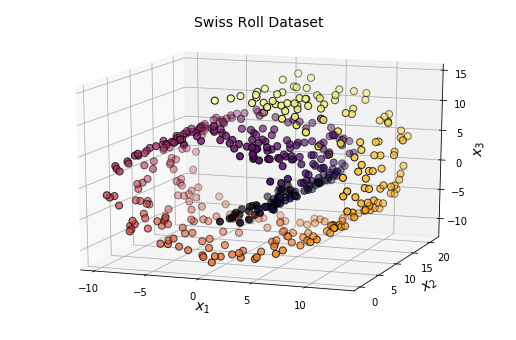

In [39]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap='inferno', lw=1, edgecolor='k', s=50)
ax.view_init(elev=15, azim=-70)
ax.set_title('Swiss Roll Dataset', fontsize=14)
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.set_zlabel("$x_3$", fontsize=14)

plt.show()

* let's project Swiss roll onto $X_1$-$X_2$ plane 
* let's unroll the dataset 

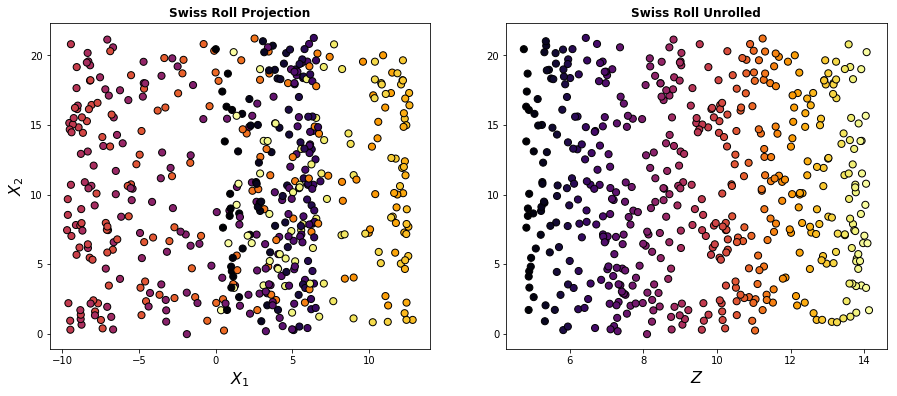

In [40]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap='inferno', lw=1, s=50, edgecolor='k')
plt.xlabel('$X_1$', fontsize=16)
plt.ylabel('$X_2$', fontsize=16)
plt.title('Swiss Roll Projection', weight='bold')

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap='inferno', lw=1, s=50, edgecolor='k')
plt.xlabel('$Z$', fontsize=16)
plt.title('Swiss Roll Unrolled', weight='bold')
plt.show()

## Manifold Learning

* Swiss Roll is an example of a 2D *manifold*.
* 2D manifold is a 2D shape bent/twisted in a higher-dimensional space
* <font color='green'>**Manifold hypothesis:**</font> Most real-world high-D datasets lie close to lower-D manifold. 
* *Another assumption*: task at hand (classification/regression) will be simpler if expressed in lower-D space of the manifold

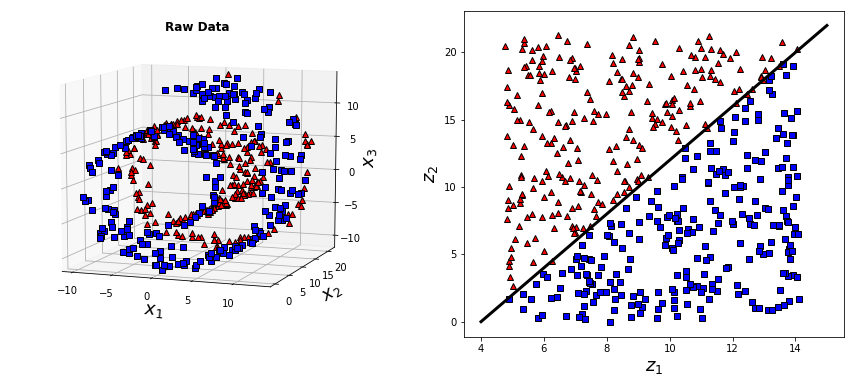

In [53]:
fig = plt.figure(figsize=(15, 6))
ax = plt.subplot(121, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "r^", lw=1, markeredgecolor='k')
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "bs", lw=1, markeredgecolor='k')
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_title("Raw Data", weight='bold')

ax = plt.subplot(122)
plt.plot(t[positive_class], X[positive_class, 1], "bs", markeredgecolor='k')
plt.plot(t[~positive_class], X[~positive_class, 1], "r^", markeredgecolor='k')
plt.plot([4, 15], [0, 22], "k-", linewidth=3)
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18)
plt.show()

* on the left the decision boundry would be complex shape but on plane it would be a straight line

### LLE

* **LLE**: Locally Linear Embedding
* *Nonlinear dimensionality reduction (NLDR)* technique
* Manifold Learning type

How it works?

1. Measures each training instance linear relation to it's neighbors
2. Looks for low-dim representation of the training set where these local relationships are best preserved

* <font color='green'>**Particularly good at unrolling twisted manifolds**</font> 
* <font color='green'>**Especially if noise is low**</font> 

Let's try LLE on Swiss Roll:

In [108]:
X, t = datasets.make_swiss_roll(n_samples=1000, noise=0.15, random_state=1)

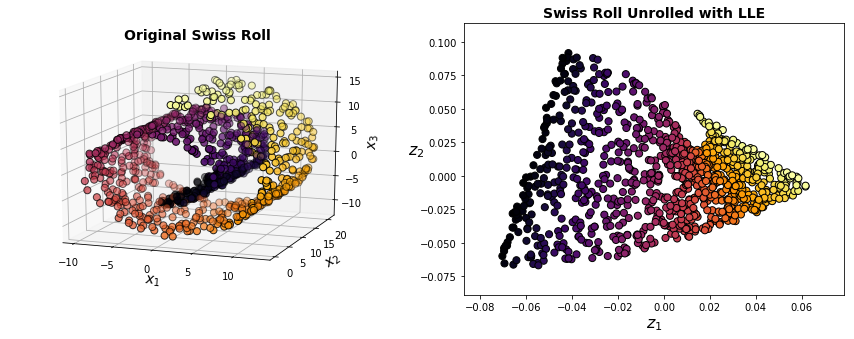

In [113]:
lle = LocallyLinearEmbedding(n_neighbors=15, n_components=2, random_state=1)
X_reduced = lle.fit_transform(X)

fig = plt.figure(figsize=(15, 5))

ax = plt.subplot(121, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap='inferno', lw=1, edgecolor='k', s=50)
ax.view_init(elev=15, azim=-70)
ax.set_title('Original Swiss Roll', fontsize=14, weight='bold')
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.set_zlabel("$x_3$", fontsize=14, rotation=0)

ax = plt.subplot(122)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, 
           cmap='inferno', lw=1, edgecolor='k', s=50)
ax.set_title('Swiss Roll Unrolled with LLE', fontsize=14, weight='bold')
ax.set_xlabel('$z_1$', fontsize=16)
ax.set_ylabel('$z_2$', fontsize=16, rotation=0)
plt.show()

* the distances are locally pretty well preserved 
* however on large scale they are not, the right part is squeezed, left part stretched

### MDS (Multidimensional Scaling)

* reduces dimensions by trying to preserve the distance between the instances

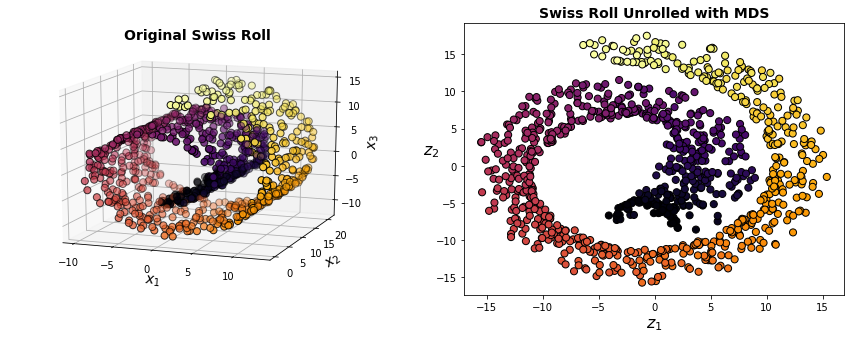

In [115]:
mds = MDS(n_components=2, random_state=3)
X_reduced = mds.fit_transform(X)

fig = plt.figure(figsize=(15, 5))

ax = plt.subplot(121, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap='inferno', lw=1, edgecolor='k', s=50)
ax.view_init(elev=15, azim=-70)
ax.set_title('Original Swiss Roll', fontsize=14, weight='bold')
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.set_zlabel("$x_3$", fontsize=14, rotation=0)

ax = plt.subplot(122)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, 
           cmap='inferno', lw=1, edgecolor='k', s=50)
ax.set_title('Swiss Roll Unrolled with MDS', fontsize=14, weight='bold')
ax.set_xlabel('$z_1$', fontsize=16)
ax.set_ylabel('$z_2$', fontsize=16, rotation=0)
plt.show()

* MDS seems to be rather slow though

### t-SNE “t-distributed Stochastic Neighbor Embedding”

* reduces dimensionality while trying to keep similar instances close and dissimilar instances apart.
* puts more emphasis on points that are close by
* it tries to preserve the information indicating which points are neighbors to each other
* mostly used for visualization

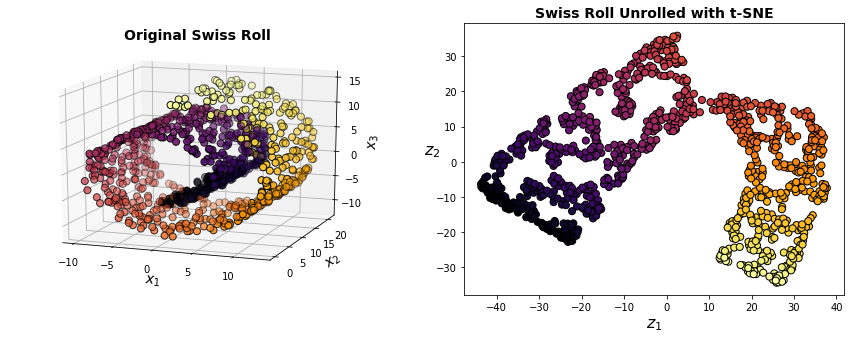

In [117]:
tsne = TSNE(n_components=2, random_state=3)
X_reduced = tsne.fit_transform(X)

fig = plt.figure(figsize=(15, 5))

ax = plt.subplot(121, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap='inferno', lw=1, edgecolor='k', s=50)
ax.view_init(elev=15, azim=-70)
ax.set_title('Original Swiss Roll', fontsize=14, weight='bold')
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.set_zlabel("$x_3$", fontsize=14, rotation=0)

ax = plt.subplot(122)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, 
           cmap='inferno', lw=1, edgecolor='k', s=50)
ax.set_title('Swiss Roll Unrolled with t-SNE', fontsize=14, weight='bold')
ax.set_xlabel('$z_1$', fontsize=16)
ax.set_ylabel('$z_2$', fontsize=16, rotation=0)
plt.show()

### Isomap

* creates a graph by connecting each instance to its nearest neighbors, then reduces dimensionality while trying to preserve the geodesic distances

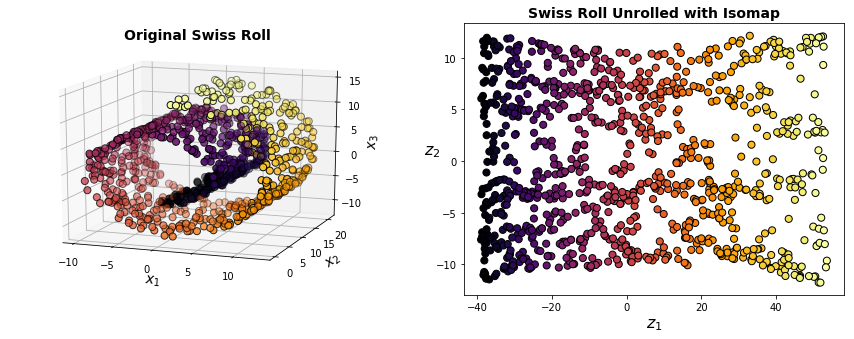

In [120]:
isomap = Isomap(n_neighbors=10, n_components=2, n_jobs=-1)
X_reduced = isomap.fit_transform(X)

fig = plt.figure(figsize=(15, 5))

ax = plt.subplot(121, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap='inferno', lw=1, edgecolor='k', s=50)
ax.view_init(elev=15, azim=-70)
ax.set_title('Original Swiss Roll', fontsize=14, weight='bold')
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.set_zlabel("$x_3$", fontsize=14, rotation=0)

ax = plt.subplot(122)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, 
           cmap='inferno', lw=1, edgecolor='k', s=50)
ax.set_title('Swiss Roll Unrolled with Isomap', fontsize=14, weight='bold')
ax.set_xlabel('$z_1$', fontsize=16)
ax.set_ylabel('$z_2$', fontsize=16, rotation=0)
plt.show()